In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def add_bollinger_bands(df: pd.DataFrame, period: int = 20, std_dev: float = 2.0) -> pd.DataFrame:
    """Add Bollinger Bands manually"""
    df = df.copy()
    df['bb_middle'] = df['close'].rolling(window=period).mean()
    bb_std = df['close'].rolling(window=period).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * std_dev)
    df['bb_lower'] = df['bb_middle'] - (bb_std * std_dev)
    df['bb_percent'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    return df

import plotly.graph_objects as go

def plot_bollinger_bands(df: pd.DataFrame, n_periods: int = 200):
    """Plot price with Bollinger Bands using Plotly candlestick chart (last n_periods candles)"""
    plot_df = df.tail(n_periods)
    fig = go.Figure()

    # Candlestick chart
    fig.add_trace(go.Candlestick(
        x=plot_df.index,
        open=plot_df['open'],
        high=plot_df['high'],
        low=plot_df['low'],
        close=plot_df['close'],
        name='Candles'
    ))

    # Bollinger Bands
    fig.add_trace(go.Scatter(
        x=plot_df.index, y=plot_df['bb_upper'],
        line=dict(color='red', width=1, dash='dash'),
        name='Upper Band'
    ))
    fig.add_trace(go.Scatter(
        x=plot_df.index, y=plot_df['bb_middle'],
        line=dict(color='blue', width=1),
        name='Middle Band'
    ))
    fig.add_trace(go.Scatter(
        x=plot_df.index, y=plot_df['bb_lower'],
        line=dict(color='green', width=1, dash='dash'),
        name='Lower Band'
    ))

    # Fill between bands
    fig.add_traces([
        go.Scatter(
            x=plot_df.index, y=plot_df['bb_upper'],
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ),
        go.Scatter(
            x=plot_df.index, y=plot_df['bb_lower'],
            mode='lines',
            fill='tonexty',
            fillcolor='rgba(0,100,80,0.1)',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        )
    ])

    fig.update_layout(
        title='Bollinger Bands (last {} candles)'.format(n_periods),
        xaxis_title='Time',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        height=600
    )
    fig.show()


In [162]:
print(df.index.max(), df.index.min())

2025-06-13 20:55:00+00:00 2024-08-01 04:00:00+00:00


In [159]:
import pandas as pd
df = pd.read_csv('hist_data/EURUSD_5min_data.csv', parse_dates=['dt'])
print(df.shape)
df = df.drop_duplicates(subset='dt')
print(df.shape)
df = add_bollinger_bands(df)

df.set_index('dt', inplace=True)

plot_bollinger_bands(df)

(81368, 5)
(64706, 5)


In [149]:
import pandas as pd
import numpy as np
import ta
from scipy.signal import find_peaks

def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """Adds a suite of technical indicators for the ML model."""
    df = df.copy()
    # --- NEW EMAs for Pullback Strategy ---
    df['ema_40'] = ta.trend.EMAIndicator(close=df['close'], window=40).ema_indicator()
    df['ema_100'] = ta.trend.EMAIndicator(close=df['close'], window=100).ema_indicator()
    # ATR for dynamic SL
    df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()
    # Stochastics
    stoch = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14, smooth_window=3)
    df['stoch_k'] = stoch.stoch()
    # Other standard indicators
    df['rsi'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
    adx = ta.trend.ADXIndicator(high=df['high'], low=df['low'], close=df['close'], window=14)
    df['adx'] = adx.adx()
    macd = ta.trend.MACD(close=df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    return df

def find_pivot_points(df: pd.DataFrame, lookback: int, prominence_pips: int, pip_size: float) -> pd.DataFrame:
    """
    Identifies pivot highs and lows using scipy.signal.find_peaks.
    A pivot is lagged by 'lookback' bars to prevent lookahead bias.
    """
    prominence_price = prominence_pips * pip_size
    high_peaks_indices, _ = find_peaks(df['high'], distance=lookback, prominence=prominence_price)
    low_peaks_indices, _ = find_peaks(-df['low'], distance=lookback, prominence=prominence_price)
    
    df['pivot_high_raw'] = np.nan
    df['pivot_low_raw'] = np.nan
    df.iloc[high_peaks_indices, df.columns.get_loc('pivot_high_raw')] = df.iloc[high_peaks_indices]['high']
    df.iloc[low_peaks_indices, df.columns.get_loc('pivot_low_raw')] = df.iloc[low_peaks_indices]['low']
    
    df['pivot_high'] = df['pivot_high_raw'].shift(lookback)
    df['pivot_low'] = df['pivot_low_raw'].shift(lookback)
    
    df = df.drop(columns=['pivot_high_raw', 'pivot_low_raw'])
    
    return df

def create_ml_dataset(df: pd.DataFrame,
                      atr_multiplier_sl: float,
                      rr_ratio: float,
                      min_sl_pips: float,
                      max_sl_pips: float,
                      slippage_pips: float,
                      spread_cost_pips: float,
                      pip_size: float = 0.0001) -> pd.DataFrame:
    """
    Creates a dataset based on a pullback to the 20 EMA within a 100 EMA trend.
    """
    print(f"--- Creating Dataset: EMA Pullback (100/20), Capped ATR SL ---")

    df_tech = add_technical_indicators(df.copy())
    df_pivots = find_pivot_points(df_tech, lookback=5, prominence_pips=5, pip_size=pip_size)

    # --- 1. Primary Trend Conditions ---
    # Uptrend: Higher pivot lows AND price is above the long-term EMA
    df_pivots['last_pl_val'] = df_pivots['pivot_low'].ffill()
    df_pivots['prev_pl_val'] = df_pivots['last_pl_val'].where(df_pivots['pivot_low'].notna()).ffill().shift()
    is_primary_uptrend = (df_pivots['last_pl_val'] > df_pivots['prev_pl_val']) & \
                         (df_pivots['close'] > df_pivots['ema_100'])
    
    # Downtrend: Lower pivot highs AND price is below the long-term EMA
    df_pivots['last_ph_val'] = df_pivots['pivot_high'].ffill()
    df_pivots['prev_ph_val'] = df_pivots['last_ph_val'].where(df_pivots['pivot_high'].notna()).ffill().shift()
    is_primary_downtrend = (df_pivots['last_ph_val'] < df_pivots['prev_ph_val']) & \
                           (df_pivots['close'] < df_pivots['ema_100'])

    # --- 2. Pullback Entry Trigger ---
    # Buy Pullback: Price closes below the short-term EMA, after being above it on the previous candle.
    buy_pullback_signal = (df_pivots['close'] < df_pivots['ema_40']) & \
                          (df_pivots['close'].shift(1) > df_pivots['ema_40'].shift(1))

    # Sell Pullback: Price closes above the short-term EMA, after being below it on the previous candle.
    sell_pullback_signal = (df_pivots['close'] > df_pivots['ema_40']) & \
                           (df_pivots['close'].shift(1) < df_pivots['ema_40'].shift(1))

    # --- 3. Combine All Conditions for Final Signal ---
    final_buy_signals = is_primary_uptrend & buy_pullback_signal
    final_sell_signals = is_primary_downtrend & sell_pullback_signal
    all_signals = final_buy_signals | final_sell_signals

    # --- 4. Process Trades (Risk management logic is unchanged) ---
    ml_data = []
    loop_indices_iloc = np.where(all_signals.to_numpy())[0]
    
    slippage_price = slippage_pips * pip_size
    spread_cost_price = spread_cost_pips * pip_size
    min_sl_price = min_sl_pips * pip_size
    max_sl_price = max_sl_pips * pip_size

    for row_iloc in loop_indices_iloc:
        if row_iloc < 1 or row_iloc >= len(df_pivots) - 50: continue
        
        signal_candle = df_pivots.iloc[row_iloc]
        entry_candle = df_pivots.iloc[row_iloc + 1]
        
        entry_price = entry_candle['open']
        is_buy_signal = final_buy_signals.iloc[row_iloc]
        
        atr_val = signal_candle['atr']
        if pd.isna(atr_val) or atr_val == 0: continue
        
        sl_dist_price = atr_val * atr_multiplier_sl
        sl_dist_price = np.clip(sl_dist_price, min_sl_price, max_sl_price)
        
        if is_buy_signal:
            sl_price = entry_price - sl_dist_price
            risk_price = entry_price - sl_price
            tp_price = entry_price + (risk_price * rr_ratio)
        else:
            sl_price = entry_price + sl_dist_price
            risk_price = sl_price - entry_price
            tp_price = entry_price - (risk_price * rr_ratio)
            
        if risk_price <= (pip_size * 2): continue

        target, pnl, outcome_determined = np.nan, np.nan, False
        dt_of_exit, exit_price_val = pd.NaT, np.nan
        
        for k in range(row_iloc + 1, row_iloc + 50):
            if k >= len(df_pivots): break
            future_candle = df_pivots.iloc[k]
            
            if is_buy_signal:
                if future_candle['low'] <= sl_price:
                    target=0; pnl=-risk_price-slippage_price-spread_cost_price; outcome_determined=True; dt_of_exit=future_candle.name; exit_price_val=sl_price; break
                if future_candle['high'] >= tp_price:
                    target=1; pnl=(risk_price*rr_ratio)-spread_cost_price; outcome_determined=True; dt_of_exit=future_candle.name; exit_price_val=tp_price; break
            else:
                if future_candle['high'] >= sl_price:
                    target=0; pnl=-risk_price-slippage_price-spread_cost_price; outcome_determined=True; dt_of_exit=future_candle.name; exit_price_val=sl_price; break
                if future_candle['low'] <= tp_price:
                    target=1; pnl=(risk_price*rr_ratio)-spread_cost_price; outcome_determined=True; dt_of_exit=future_candle.name; exit_price_val=tp_price; break
        
        if not outcome_determined: continue
        
        features_to_exclude = {col for col in signal_candle.index if 'pivot' in col or 'last_' in col or 'prev_' in col or 'ema_50' in col}
        features = {k: v for k, v in signal_candle.to_dict().items() if k not in features_to_exclude}

        features.update({
            'dt_of_break': signal_candle.name,
            'dt_of_entry': entry_candle.name,
            'entry_price': entry_price,
            'target': target,
            'pnl': pnl,
            'break_type': 1 if is_buy_signal else 0,
            'dt_of_exit': dt_of_exit,
            'exit_price': exit_price_val,
            'tp_price': tp_price,
            'sl_price': sl_price,
        })
        ml_data.append(features)

    if not ml_data:
        print("No training samples generated after processing.")
        return pd.DataFrame()
        
    ml_df = pd.DataFrame(ml_data)
    ml_df = ml_df.drop_duplicates(subset='dt_of_break', keep='first')
    ml_df = ml_df.dropna(subset=[col for col in ml_df.columns if col not in ['dt_of_break', 'volume_ratio', 'dt_of_exit']])
    
    if ml_df.empty:
        print("No training samples generated after dropna.")
        return ml_df

    ml_df['pnl'] = (ml_df['pnl'] / pip_size).astype(float)
    ml_df['target'] = ml_df['target'].astype(int)
    
    ml_df = ml_df.set_index('dt_of_break')
    
    print(f"Created {len(ml_df)} training samples.")
    if len(ml_df) > 0:
        print(f"Win Rate (target=1): {ml_df['target'].mean():.2%}")
        print(f"Overall Expectancy (incl. costs): {ml_df['pnl'].mean():.4f} pips/trade")
    
    return ml_df

# --- USAGE EXAMPLE ---
orig_dataset = create_ml_dataset(
    df, 
    atr_multiplier_sl=2.0, 
    rr_ratio=1.5,
    min_sl_pips=10.0,
    max_sl_pips=25.0,
    slippage_pips=0.5, 
    spread_cost_pips=1.0
)

--- Creating Dataset: EMA Pullback (100/20), Capped ATR SL ---
Created 49 training samples.
Win Rate (target=1): 51.02%
Overall Expectancy (incl. costs): 1.6959 pips/trade



--- Starting Walk-Forward Validation with 5 Splits ---

--- Fold 1/5 ---
Train: 9 samples (2024-08-05 to 2024-11-14)
Test:  8 samples (2024-11-25 to 2024-12-16)
Fold Precision: 62.50%
Fold Strategy PnL: 30.42 pips

--- Fold 2/5 ---
Train: 17 samples (2024-08-05 to 2024-12-16)
Test:  8 samples (2024-12-19 to 2025-01-14)
Fold Precision: 50.00%
Fold Strategy PnL: 14.81 pips

--- Fold 3/5 ---
Train: 25 samples (2024-08-05 to 2025-01-14)
Test:  8 samples (2025-01-16 to 2025-03-06)
Fold Precision: 37.50%
Fold Strategy PnL: -13.31 pips

--- Fold 4/5 ---
Train: 33 samples (2024-08-05 to 2025-03-06)
Test:  8 samples (2025-03-31 to 2025-05-19)
Fold Precision: 62.50%
Fold Strategy PnL: 51.53 pips

--- Fold 5/5 ---
Train: 41 samples (2024-08-05 to 2025-05-19)
Test:  8 samples (2025-05-23 to 2025-06-12)
Fold Precision: 40.00%
Fold Strategy PnL: -9.21 pips


VALIDATION SUMMARY
Total Strategy PnL: 74.23 pips
Average PnL per fold: 14.85 pips
Overall Precision: 51.35%


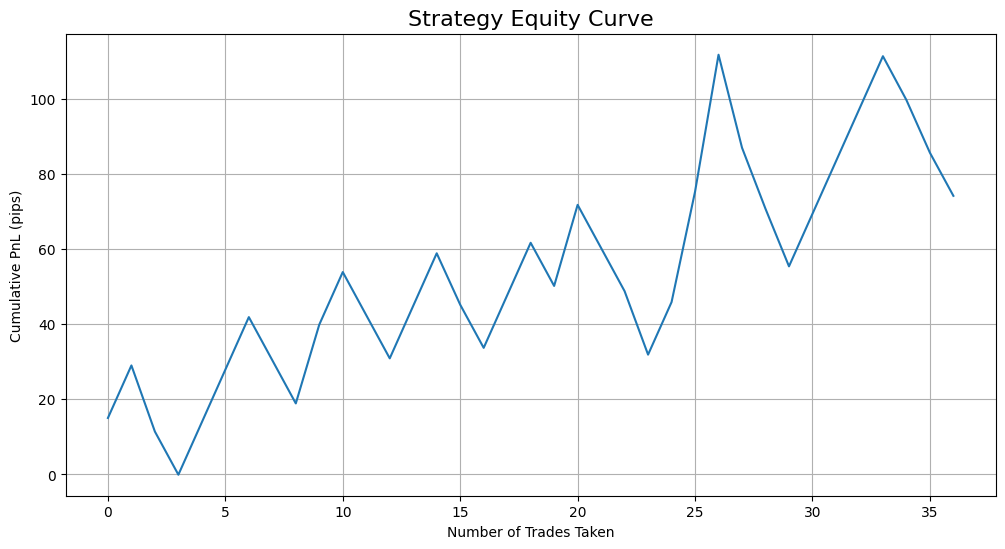

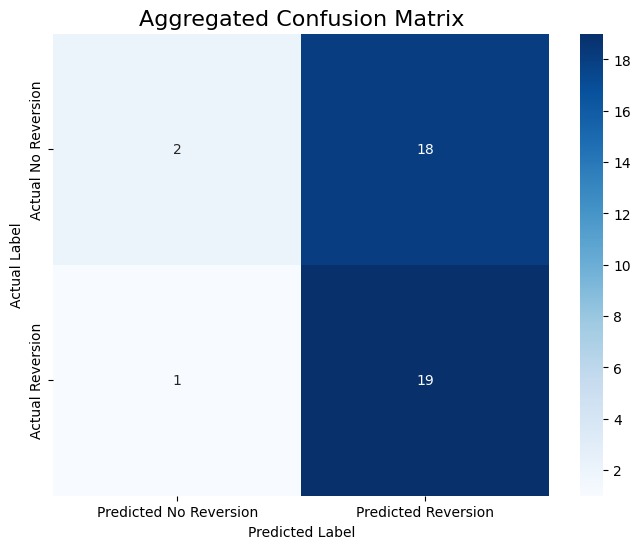

In [150]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# --- 1. Prepare Data ---
ml_dataset = orig_dataset.copy()#.set_index('dt_of_break').sort_index()

# Now that 'dt_of_break' is the index, it won't be in the columns to drop.
X = ml_dataset.drop(['dt_of_exit', 'exit_price', 'tp_price', 'sl_price', 'break_type', 'pnl', 'target','dt_of_entry', 'entry_price'], axis=1)
# X = ml_dataset.drop(['break_type', 'pnl', 'target'], axis=1)
y = ml_dataset['target']
pnl = ml_dataset['pnl']
X.columns = [str(col) for col in X.columns]

# --- 2. Set up and Run Walk-Forward Cross-Validation ---
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

print(f"\n--- Starting Walk-Forward Validation with {n_splits} Splits ---")

all_y_test, all_y_pred, fold_pnl = [], [], []
equity_curve_pnl = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    pnl_test = pnl.iloc[test_index]
    
    print(f"\n--- Fold {fold + 1}/{n_splits} ---")
    # This print statement will now work correctly
    print(f"Train: {len(X_train)} samples ({X_train.index.min().date()} to {X_train.index.max().date()})")
    print(f"Test:  {len(X_test)} samples ({X_test.index.min().date()} to {X_test.index.max().date()})")

    lgbm = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', random_state=42, verbose=-1)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    
    strategy_pnl_fold = pnl_test[y_pred == 1].sum()
    fold_pnl.append(strategy_pnl_fold)
    equity_curve_pnl.extend(pnl_test[y_pred == 1])
    
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

    print(f"Fold Precision: {precision_score(y_test, y_pred, zero_division=0):.2%}")
    print(f"Fold Strategy PnL: {strategy_pnl_fold:.2f} pips")

# --- 3. Final Aggregated Results ---
print(f"\n\n{'='*50}\nVALIDATION SUMMARY\n{'='*50}")
print(f"Total Strategy PnL: {np.sum(fold_pnl):.2f} pips")
print(f"Average PnL per fold: {np.mean(fold_pnl):.2f} pips")
print(f"Overall Precision: {precision_score(all_y_test, all_y_pred, zero_division=0):.2%}")

# --- 4. Plot Equity Curve ---
equity_curve = np.cumsum(equity_curve_pnl)
plt.figure(figsize=(12, 6))
plt.plot(equity_curve)
plt.title('Strategy Equity Curve', fontsize=16)
plt.xlabel('Number of Trades Taken'); plt.ylabel('Cumulative PnL (pips)')
plt.grid(True); plt.show()

# --- 5. Plot Confusion Matrix ---
cm = confusion_matrix(all_y_test, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Reversion', 'Predicted Reversion'], 
            yticklabels=['Actual No Reversion', 'Actual Reversion'])
plt.title('Aggregated Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label'); plt.xlabel('Predicted Label'); plt.show()

In [98]:
# save lgbm model as joblib
import joblib
# Save the trained model to a file
joblib.dump(lgbm, 'lgbm_model.joblib')

# In your model training notebook, after creating X_train:
import json

# Get the list of feature names in the correct order
model_features = X_train.columns.tolist()

# Save the list to a JSON file
with open('model_features.json', 'w') as f:
    json.dump(model_features, f, indent=4)

# Next Steps:
1. adjust for multiple pairs
1. Plot some sample trades
1. Add slippage and commission to the backtest
1. test calculated SL
1. Check furthest back date that can get data on
1. ~~Start testing on live data using API~~

In [151]:
import pandas as pd
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_sample_trades_plotly(
    trades_df: pd.DataFrame,
    full_indicator_df: pd.DataFrame,
    num_to_plot: int = 5
):
    """
    Plots a random sample of trades with pivot points, entry/exit markers, and TP/SL levels.
    Updated to show 20 and 100 EMAs for the pullback strategy.
    """
    if trades_df.empty:
        print("No trades to plot.")
        return
        
    num_to_plot = min(num_to_plot, len(trades_df))
    sample_trades = trades_df.sample(n=num_to_plot, random_state=43)

    print(f"\n--- Plotting {num_to_plot} Sample Trades using Plotly ---")

    for signal_timestamp, trade_info in sample_trades.iterrows():
        # --- 1. Prepare Data Window ---
        entry_loc = full_indicator_df.index.get_loc(signal_timestamp)
        start_loc = max(0, entry_loc - 60)
        end_loc = min(len(full_indicator_df), entry_loc + 40)
        plot_df = full_indicator_df.iloc[start_loc:end_loc]

        # --- 2. Create the Plot ---
        fig = go.Figure()

        fig.add_trace(go.Candlestick(x=plot_df.index, open=plot_df['open'], high=plot_df['high'], low=plot_df['low'], close=plot_df['close'], name='Candles'))
        # --- UPDATED EMAs ---
        fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['ema_40'], mode='lines', name='40 EMA', line=dict(color='blue', width=1)))
        fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['ema_100'], mode='lines', name='100 EMA', line=dict(color='purple', width=1.5)))
        
        fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['pivot_high'], mode='markers', name='Pivot High', marker=dict(symbol='triangle-down', color='red', size=9)))
        fig.add_trace(go.Scatter(x=plot_df.index, y=plot_df['pivot_low'], mode='markers', name='Pivot Low', marker=dict(symbol='triangle-up', color='lime', size=9)))

        # --- 3. Add Trade Markers and Lines ---
        trade_type = "BUY" if trade_info['break_type'] == 1 else "SELL"
        pnl_color = 'green' if trade_info['pnl'] > 0 else 'red'
        
        entry_timestamp = trade_info['dt_of_entry']
        entry_price = trade_info['entry_price']
        exit_timestamp = trade_info['dt_of_exit']
        exit_price = trade_info['exit_price']
        
        fig.add_hline(y=trade_info['tp_price'], line_dash="dot", line_color="green", line_width=1)
        fig.add_hline(y=trade_info['sl_price'], line_dash="dot", line_color="red", line_width=1)

        fig.add_trace(go.Scatter(
            x=[entry_timestamp, exit_timestamp],
            y=[entry_price, exit_price],
            mode='markers+lines',
            line=dict(color=pnl_color, width=2, dash='dash'),
            marker=dict(symbol=['arrow-bar-up' if trade_type=="BUY" else 'arrow-bar-down', 'x'], 
                        color=pnl_color, size=[10, 12]),
            name='Trade Path'
        ))

        # --- 4. Finalize Layout ---
        title_str = f"Trade Setup on {signal_timestamp.date()}: {trade_type} | PnL: {trade_info['pnl']:.2f} pips"
        fig.update_layout(title_text=title_str, xaxis_rangeslider_visible=False, height=600)
        fig.update_yaxes(title_text="Price")
        
        fig.show()


# --- CORRECTED USAGE EXAMPLE ---
# This code assumes it's run after the validation loop cell.

# 1. Re-create the full dataframe with all indicators (including new EMAs) AND pivots
full_indicator_df = add_technical_indicators(df.copy())
full_indicator_df = find_pivot_points(full_indicator_df, lookback=5, prominence_pips=5, pip_size=0.0001)

# 2. Reconstruct the test set dataframe to prevent data misalignment
test_set_indices = X_test.index
test_set_df = orig_dataset.loc[test_set_indices].copy()

# 3. Add the prediction results to this clean dataframe
test_set_df['predicted'] = y_pred

# 4. Filter for trades the model decided to take
trades_taken_by_model = test_set_df[test_set_df['predicted'] == 1].dropna(subset=['dt_of_exit'])

# 5. Call the plotting function with the corrected dataframe
plot_sample_trades_plotly(
    trades_df=trades_taken_by_model,
    full_indicator_df=full_indicator_df,
    num_to_plot=5
)


--- Plotting 5 Sample Trades using Plotly ---
